In this notebook, first i'm using VGG16's architecture to train the model on CIFAR10 dataset and then i use the pretrained model on imagenet dataset to get quick results for comparison.

In [35]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score

from ipywidgets import interact, interactive_output, fixed
import ipywidgets as widgets

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

Text(0.5, 1.0, 'ships')

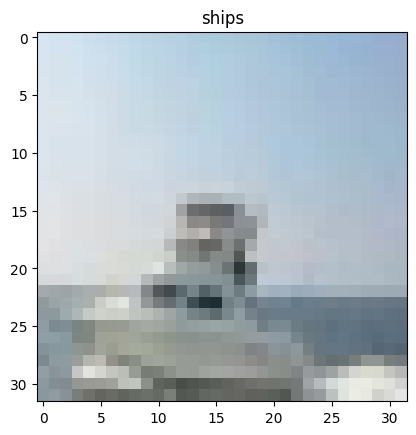

In [5]:
labels = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

idx = 100

plt.imshow(X_train[idx])
plt.title(labels[y_train[idx][0]])

In [6]:
X_train, X_test = X_train / 255., X_test / 255.

In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

For complexity reasons, the VGG model has to be simplified for such a dataset, so we will only keep the first layers :

First we start with a model with no pretrainted weights and train some of its layers on our data.

In [8]:
base_model_raw = VGG16()
base_model_raw.summary()

2024-09-02 00:34:59.137340: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-02 00:34:59.137711: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-02 00:34:59.137735: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-02 00:34:59.137784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-02 00:34:59.138153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
base_model = VGG16(weights=None, include_top=False, input_shape=X_train.shape[1:])

x = base_model.get_layer('block3_pool').output # considering only last layers starting from block3_pool layer
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,838,282 (14.64 MB)

 Trainable params: 3,838,282 (14.64 MB)

 Non-trainable params: 0 (0.00 B)

Now let's try the model

In [11]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
cb = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, min_delta=0.001)
]

In [13]:
model.fit(X_train, y_train, validation_split=.2, batch_size=32, epochs=100, callbacks=cb)

Epoch 1/100


2024-09-02 00:35:09.973160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 50ms/step - accuracy: 0.2198 - loss: 2.0455 - val_accuracy: 0.5135 - val_loss: 1.3673 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.5420 - loss: 1.2650 - val_accuracy: 0.6085 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.6378 - loss: 1.0225 - val_accuracy: 0.6459 - val_loss: 0.9872 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.6984 - loss: 0.8531 - val_accuracy: 0.6894 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.7424 - loss: 0.7308 - val_accuracy: 0.6891 - val_loss: 0.9229 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.7769 - loss: 0.6292 - val_accuracy: 0.7185 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0

The training took me about 16min which is (relatively) long.

In [14]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [15]:
y_pred_train = to_categorical(train_pred.argmax(axis=1), num_classes=10)
y_pred_test = to_categorical(test_pred.argmax(axis=1), num_classes=10)

print('accuracy on train set with NN:', accuracy_score(y_pred_train, y_train))
print('accuracy on test set with NN:', accuracy_score(y_pred_test, y_test))


accuracy on train set with NN: 0.83844
accuracy on test set with NN: 0.7258


### Using the pretrained weights from image net

In [16]:
base_model_pretrained = VGG16(weights='imagenet', include_top=False,
             input_shape=X_train.shape[1:])

In [17]:
for l in base_model.layers:
    l.trainable = False

x = base_model.get_layer('block3_pool').output

x = Flatten(name='Flatten')(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2=0.001))(x)
predictions = Dense(10, activation='softmax')(x)

model_pretrained = Model(inputs=base_model.input, outputs=predictions)

model_pretrained.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_pretrained.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,838,282 (14.64 MB)

 Trainable params: 2,102,794 (8.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [19]:
cb = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, min_delta=0.001)
]

In [20]:
model_pretrained.fit(X_train, y_train, validation_split=.2, batch_size=32, epochs=100, callbacks=cb)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7449 - loss: 0.9566 - val_accuracy: 0.7272 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.8121 - loss: 0.6959 - val_accuracy: 0.7297 - val_loss: 0.9653 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8193 - loss: 0.6743 - val_accuracy: 0.7316 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8290 - loss: 0.6505 - val_accuracy: 0.7330 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.8346 - loss: 0.6194 - val_accuracy: 0.7431 - val_loss: 0.9461 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8383 - loss: 0.6114 - val_accuracy: 0.7338 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step -

Using the pretrained model fitting the data took me 11min. And the accuracy of the model is even better !

In [21]:
y_pred_train = to_categorical(model_pretrained.predict(X_train).argmax(axis=1), num_classes=10)
y_pred_test = to_categorical(model_pretrained.predict(X_test).argmax(axis=1), num_classes=10)

print('accuracy on train with NN:', accuracy_score(y_pred_train, y_train))
print('accuracy on test with NN:', accuracy_score(y_pred_test, y_test))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
accuracy on train with NN: 0.88676
accuracy on test with NN: 0.7428


#### See what's inside

In [22]:
mods = { f"b{i}" : Model(inputs=base_model_pretrained.input, outputs=base_model_pretrained.get_layer(f"block{i}_pool").output) for i in range(1, 6)}

In [ ]:
def plot_feature_map(idx, block, channel):
    # Get the prediction for the selected image
    pred = mods[f'b{block}'].predict(np.expand_dims(X_test[idx], axis=0))
    pred = pred.squeeze(axis=0)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.imshow(X_test[idx])
    ax1.set_title(f"Original: {labels[y_test[idx].argmax()]}", fontsize=8) 
    ax1.axis('off')

    # Plot feature map
    im = ax2.imshow(pred[:, :, channel], cmap='cividis')
    ax2.set_title(f"Feature Map: B{block}, Ch{channel}", fontsize=8) 
    ax2.axis('off')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2, orientation='vertical', label='Activation', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('Activation', fontsize=7)

    plt.tight_layout()
    plt.show()

# Create interactive widgets
idx_widget = widgets.IntSlider(min=0, max=99, step=1, value=10, description='Image:', style={'description_width': 'initial'})
block_widget = widgets.IntSlider(min=1, max=5, step=1, value=1, description='Block:', style={'description_width': 'initial'})
channel_widget = widgets.IntSlider(min=0, max=63, step=1, value=0, description='Channel:', style={'description_width': 'initial'})

# Create interactive output
interactive_plot = interactive_output(plot_feature_map, {'idx': idx_widget, 'block': block_widget, 'channel': channel_widget})

# Display widgets and plot
display(widgets.VBox([widgets.HBox([idx_widget, block_widget, channel_widget]), interactive_plot]))

### Data Augmentation

In [38]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    preprocessing_function=preprocess_input
)

# Model Architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
import os
os.makedirs('./ckpt', exist_ok=True)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('./ckpt/best_model.keras', save_best_only=True)
]
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,114,314 (57.66 MB)

 Trainable params: 398,090 (1.52 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [ ]:
# Fit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=callbacks
)

In [ ]:
# Fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")